In [1]:
import os
import pandas as pd

In [2]:
cwd = os.getcwd()
cwd

'/home/connor/code/zulu-tango/news_and_echo_bubbles/notebooks'

In [3]:
parent = os.path.dirname(cwd)
parent

'/home/connor/code/zulu-tango/news_and_echo_bubbles'

In [4]:
data_folder = os.path.join(parent,"raw_data")
data_folder

'/home/connor/code/zulu-tango/news_and_echo_bubbles/raw_data'

In [5]:
left_data_location = os.path.join(data_folder,"braindedleft.csv")
right_data_location = os.path.join(data_folder,"braindedright.csv")

In [6]:
# load in left and right datasets
df_left = pd.read_csv(left_data_location)
df_right = pd.read_csv(right_data_location)

In [7]:
# assign a 0 to left wing articles and a 1 to right wing articles
df_left["ideology"] = 0
df_right["ideology"] = 1

In [8]:
# merge the two datasets
merged_df = pd.concat([df_left,df_right])

In [9]:
merged_df.head(1)

,Unnamed: 0,link,pdate,title,author,text,keywords,tags,compound,neg,neu,pos,polarity,subjectivity,ideology
0,0,https://kindest.com/442355-defend-democracy-to...,NaN,"Defend Democracy Today: Support Fearless, Insi...",[],"While the election has come and gone, the figh...","['reporting', 'come', 'today', 'access', 'chec...",set(),0.8612,0.063,0.819,0.118,0.165589,0.539782,0


In [10]:
merged_df.tail(1)

,Unnamed: 0,link,pdate,title,author,text,keywords,tags,compound,neg,neu,pos,polarity,subjectivity,ideology
1809,1809,https://americanmind.org/video/book-talk-crisi...,NaN,The American Mind Podcast: The Roundtable Epis...,"['Christopher Buskirk', 'Kevin Portteus', 'Dan...",The American Mind’s ‘Editorial Roundtable’ pod...,"['mind', 'williams', 'trump', 'american', 'unc...",set(),0.6808,0.026,0.9,0.074,0.114815,0.296296,1


In [11]:
# drop unnecessary columns
# we may not want to drop all of these for later analysis, but this is fine for now
merged_df = merged_df.drop(columns = ["Unnamed: 0", "link", "pdate", "title", "author",	"keywords",\
                          "tags", "compound", "neg", "neu", "pos", "polarity", "subjectivity"])

In [12]:
# taking a sample to make testing the model easier
df_sample = merged_df.sample(100)

In [13]:
# check data is balanced between left-wing and right-wing (i.e. c.250 of each class)
df_sample["ideology"].sum()

37

In [14]:
!pip install tensorflow transformers

In [15]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

2023-11-28 10:50:57.114006: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 10:50:57.165458: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 10:50:57.402359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 10:50:57.402402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 10:50:57.447014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [16]:
df_sample.head()

,text,ideology
1218,There was this telling exchange on Sunday on M...,1
854,NaN,1
511,A newly declassified report from the director ...,0
903,Screenshot : Destroying Giant Stress Balls ( Y...,1
161,The number of migrant children now held in U.S...,1


In [17]:
# see what the lengths of the texts are
# need to convert texts to string first before calculating length, as I was getting an error that some texts were float values and not strings
# this should be fixed during pre-processing
# using a basic split by spaces and no other delimiters
df_sample["text_length"] = df_sample["text"].apply(lambda x: len(str(x).split()))

In [18]:
df_sample.head()

,text,ideology,text_length
1218,There was this telling exchange on Sunday on M...,1,179
854,NaN,1,1
511,A newly declassified report from the director ...,0,734
903,Screenshot : Destroying Giant Stress Balls ( Y...,1,189
161,The number of migrant children now held in U.S...,1,402


In [19]:
df_sample = df_sample.dropna()
df_sample

,text,ideology,text_length
1218,There was this telling exchange on Sunday on M...,1,179
511,A newly declassified report from the director ...,0,734
903,Screenshot : Destroying Giant Stress Balls ( Y...,1,189
161,The number of migrant children now held in U.S...,1,402
1201,"In April 2020, as the world was coming to term...",0,1051
...,...,...,...
948,"Qi Bing, University of California, Irvine and ...",0,1131
213,national security concern\n\nRussian interfere...,0,6047
1667,"This week’s contest\n\nEach week, we provide a...",0,74
1972,Let our journalists help you make sense of the...,0,496


In [20]:
# 37 rows were dropped in this, therefore there must have been many NaN values
# these will be dropped during preprocessing, so this is fine

In [21]:
import matplotlib.pyplot as plt

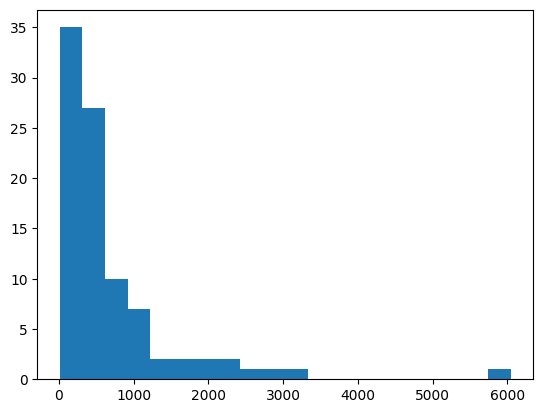

In [22]:
# view histogram of lengths of sample texts
plt.hist(df_sample["text_length"], bins = 20);

In [23]:
# based on ths histogram, let's use a max length of 1,000

In [24]:
# import the tokenizer from DistilBert to tokenize our texts (i.e. turn them into numbers)
# the tokeninzer will give each word one number (or more if it uses sub-word tokenization)
# after this step, the DistilBert transformer will encode these tokens into vectors when it runs
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [25]:
# reset the index in our sample data frame to 0
df_sample = df_sample.reset_index(drop=True)
df_sample

,text,ideology,text_length
0,There was this telling exchange on Sunday on M...,1,179
1,A newly declassified report from the director ...,0,734
2,Screenshot : Destroying Giant Stress Balls ( Y...,1,189
3,The number of migrant children now held in U.S...,1,402
4,"In April 2020, as the world was coming to term...",0,1051
...,...,...,...
86,"Qi Bing, University of California, Irvine and ...",0,1131
87,national security concern\n\nRussian interfere...,0,6047
88,"This week’s contest\n\nEach week, we provide a...",0,74
89,Let our journalists help you make sense of the...,0,496


In [26]:
df_sample["text"][0]

'There was this telling exchange on Sunday on Meet the Press between Chuck Todd and Raphael Warnock:\n\nCHUCK TODD: I appreciate it. I want to start with something that the FBI director said this week. Director Wray said it does not appear the shooting was racially motivated. So, this is now the FBI director. We’ve heard local law enforcement. What are your — are you hearing the same thing from law enforcement that you’ve been speaking with?\n\nSEN. RAPHAEL WARNOCK: Well, first of all, let me say that our hearts go out to these families as they are dealing with unspeakable loss. I think it’s important that we center the humanity of the victims. I’m hearing a lot about the shooter, but these precious lives that have been lost, they are attached to families. They’re, you know, they’re connected to people who love them. And so, we need to keep that in mind. I know that — look, law enforcement will go through the work that they need to do, but we all know hate when we see it.'

In [27]:
# example tokenization with max length of 1000
# "truncation" means that texts longer than max_length will be cut off
# "padding" means that tokens with zeroes will be added to the end of token outputs to ensure a length of max_length for all tokenized texts

max_length = 1000

example_tokens = tokenizer(df_sample["text"][0], max_length = max_length, truncation = True, padding = "max_length")
example_tokens

{'input_ids': [101, 2045, 2001, 2023, 4129, 3863, 2006, 4465, 2006, 3113, 1996, 2811, 2090, 8057, 6927, 1998, 12551, 11582, 7432, 1024, 8057, 6927, 1024, 1045, 9120, 2009, 1012, 1045, 2215, 2000, 2707, 2007, 2242, 2008, 1996, 8495, 2472, 2056, 2023, 2733, 1012, 2472, 23277, 4710, 2056, 2009, 2515, 2025, 3711, 1996, 5008, 2001, 5762, 2135, 12774, 1012, 2061, 1010, 2023, 2003, 2085, 1996, 8495, 2472, 1012, 2057, 1521, 2310, 2657, 2334, 2375, 7285, 1012, 2054, 2024, 2115, 1517, 2024, 2017, 4994, 1996, 2168, 2518, 2013, 2375, 7285, 2008, 2017, 1521, 2310, 2042, 4092, 2007, 1029, 12411, 1012, 12551, 11582, 7432, 1024, 2092, 1010, 2034, 1997, 2035, 1010, 2292, 2033, 2360, 2008, 2256, 8072, 2175, 2041, 2000, 2122, 2945, 2004, 2027, 2024, 7149, 2007, 4895, 13102, 25508, 3085, 3279, 1012, 1045, 2228, 2009, 1521, 1055, 2590, 2008, 2057, 2415, 1996, 8438, 1997, 1996, 5694, 1012, 1045, 1521, 1049, 4994, 1037, 2843, 2055, 1996, 13108, 1010, 2021, 2122, 9062, 3268, 2008, 2031, 2042, 2439, 1010, 2027

In [28]:
# checking the length of the tokens with an example
len(example_tokens["input_ids"])

1000

In [29]:
import numpy as np

In [30]:
# using a max_len of 50 here to save time making the encodings
def construct_tokens(x, tokenizer, max_len = 100, truncation = True, padding = "max_length"):
    return tokenizer(x, max_length = max_len, truncation = truncation, padding = padding)

In [31]:
construct_tokens(df_sample["text"][0], tokenizer)

{'input_ids': [101, 2045, 2001, 2023, 4129, 3863, 2006, 4465, 2006, 3113, 1996, 2811, 2090, 8057, 6927, 1998, 12551, 11582, 7432, 1024, 8057, 6927, 1024, 1045, 9120, 2009, 1012, 1045, 2215, 2000, 2707, 2007, 2242, 2008, 1996, 8495, 2472, 2056, 2023, 2733, 1012, 2472, 23277, 4710, 2056, 2009, 2515, 2025, 3711, 1996, 5008, 2001, 5762, 2135, 12774, 1012, 2061, 1010, 2023, 2003, 2085, 1996, 8495, 2472, 1012, 2057, 1521, 2310, 2657, 2334, 2375, 7285, 1012, 2054, 2024, 2115, 1517, 2024, 2017, 4994, 1996, 2168, 2518, 2013, 2375, 7285, 2008, 2017, 1521, 2310, 2042, 4092, 2007, 1029, 12411, 1012, 12551, 11582, 7432, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [32]:
# define our x and y from the dataset
x = df_sample["text"].tolist()
y = df_sample["ideology"].tolist()

In [ ]:
tokens = construct_tokens(x, tokenizer)
tokens

In [ ]:
def construct_tfdataset(tokens, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(tokens),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(tokens))
    
tfdataset = construct_tfdataset(tokens, y)
tfdataset

### adding in z to get the index!!!!!!!!!!!!!!

In [ ]:
list(tfdataset.as_numpy_iterator()) 

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

In [ ]:
train_size = int(len(x) * (1-TEST_SPLIT))

In [ ]:
train_size

In [ ]:
#### firstly shuffle
#### then take the train and the test sets

In [ ]:
tfdataset_shuffled = tfdataset.shuffle(len(x))

In [ ]:
tfdataset_train = tfdataset_shuffled.take(train_size)
tfdataset_test = tfdataset_shuffled.skip(train_size)

In [ ]:
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
epochs = 2
model_name = "distilbert-base-uncased"

# set up model
model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

# define optimizer to be used to minimise loss
optimizer = optimizers.Adam(learning_rate=3e-5)

# define loss function
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

# compile model
model.compile(optimizer = optimizer,
              loss = loss,
              metrics = "accuracy")
# fit model
model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=epochs)

In [ ]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

In [ ]:
# the accuracy is not very good, as it is only 0.54. Baseline accuracy = 0.5
# could probably improve the accuracy by increasing the length of each article? (currently set to 50 words)
# accuracy will also be increased with better text preprocessing?
# accuracy could also be increased with more epochs (but this takes a long time) - could train on google Colab instead?
# should also set it up so that it uses validation splits in the model compilation?

In [ ]:
tfdataset = tf.data.Dataset.from_tensor_slices(dict(tokens))
testing = model.predict(tfdataset)
testing[0]

In [ ]:
temp = testing[0][0]
temp

In [ ]:
tf.nn.softmax(temp)

## TESTING FUNCTIONS

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
BATCH_SIZE = 2
LEARNING_RATE = 3e-5
TOKEN_MAX_LEN = 50
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.3
EPOCHS = 5
PATIENCE = 2

In [35]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

### testing the text_tokenizer function

In [36]:
def text_tokenizer(X,
                   tokenizer,
                   max_len = TOKEN_MAX_LEN,
                   truncation = True,
                   padding = "max_length"):
    """
    Returns a dictionary of tokenized text with 2 keys: "input_ids" and "attention_mask".
    These 2 keys are required for the input to the DistilBert model.
    """
    
    tokens = tokenizer(X, max_length = max_len, truncation = truncation, padding = padding)
    
    return tokens

In [37]:
tokens = text_tokenizer(x, tokenizer)

### testing the tf_dataset_constructor function

In [38]:
def tf_dataset_constructor(tokens,
                           y):
    """
    Using the tokenized input from the text_tokenizer function, returns TensorFlow objects for use in the DistilBert model.
    """

    tfdataset = tf.data.Dataset.from_tensor_slices((dict(tokens),y))
        
    return tfdataset

In [39]:
tfdataset = tf_dataset_constructor(tokens, y)

In [40]:
type(tfdataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

### testing the train_test_split function

In [41]:
def train_test_split(X,
                     tfdataset,
                     test_split = TEST_SPLIT,
                     val_split = VALIDATION_SPLIT,
                     batch_size = BATCH_SIZE):
    """
    This function splits the TensorFlow object created in the tf_dataset_constructor function into train and test sets.
    """
    
    train_size = int(len(X) * (1-test_split))
    val_size = int(train_size * val_split)
    
    tfdataset = tfdataset.shuffle(len(X))
    
    tfdataset_train = tfdataset.take(train_size)
    tfdataset_val = tfdataset.skip(train_size - val_size).take(val_size)
    tfdataset_test = tfdataset.skip(train_size)
    
    tfdataset_train = tfdataset_train.batch(batch_size)
    tfdataset_val = tfdataset_val.batch(batch_size)
    tfdataset_test = tfdataset_test.batch(batch_size)

    return tfdataset_train, tfdataset_val, tfdataset_test

In [42]:
tfdataset_train, tfdataset_val, tfdataset_test = train_test_split(x, tfdataset)

In [43]:
type(tfdataset_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [44]:
type(tfdataset_val)

tensorflow.python.data.ops.batch_op._BatchDataset

In [45]:
type(tfdataset_test)

tensorflow.python.data.ops.batch_op._BatchDataset

### testing the ideology_model function

In [46]:
def ideology_model(tfdataset_train,
                   tfdataset_val,
                   model_name = "distilbert-base-uncased",
                   learning_rate = LEARNING_RATE,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   patience = PATIENCE):
            
    """
    Set up an run a DistilBert model on our TensorFlow training dataset.
    """
    
    # set up model
    model = TFDistilBertForSequenceClassification.from_pretrained(model_name)
    
    # define loss function
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)

    # define optimizer to be used to minimise loss
    optimizer = optimizers.Adam(learning_rate)
    
    # compile model
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = "accuracy")
    
    # fit model
    model.fit(tfdataset_train,
              batch_size = batch_size,
              epochs = epochs,
              validation_data = tfdataset_val,
              callbacks = EarlyStopping(patience = PATIENCE, restore_best_weights = True))

    return model

In [47]:
model = ideology_model(tfdataset_train, tfdataset_val)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
36/36 [==============================] - 30s 613ms/step - loss: 0.6422 - accuracy: 0.6944 - val_loss: 0.5601 - val_accuracy: 0.6667
Epoch 2/5
36/36 [==============================] - 21s 575ms/step - loss: 0.5057 - accuracy: 0.7639 - val_loss: 0.4138 - val_accuracy: 0.7143
Epoch 3/5
36/36 [==============================] - 23s 632ms/step - loss: 0.2649 - accuracy: 0.8889 - val_loss: 0.0963 - val_accuracy: 1.0000
Epoch 4/5
36/36 [==============================] - 22s 600ms/step - loss: 0.0949 - accuracy: 0.9722 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 5/5
36/36 [==============================] - 21s 583ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000


### testing the ideology_model_evaluator function

In [48]:
def ideology_model_evaluator(model,
                             tfdataset_test,
                             batch_size = BATCH_SIZE):
    """
    Evaluate our model on the TensorFlow test dataset
    """
    
    benchmarks = model.evaluate(tfdataset_test, batch_size = batch_size, return_dict = True)
    accuracy = benchmarks["accuracy"]
    
    return accuracy

In [49]:
accuracy = ideology_model_evaluator(model, tfdataset_test)

10/10 [==============================] - 1s 86ms/step - loss: 0.0106 - accuracy: 1.0000


In [50]:
accuracy

1.0

### testing the ideology_model_predictor function

In [51]:
def ideology_model_predictor(model,
                             tokens):
    """
    This function uses the model output from the ideology_model function to output the probabilities of each
    individual article being left or right wing (0 = left wing, 1 = right wing). As the model spits out log odds
    rather than probabilities, these also need to be converted in this function into probabilities
    """
    # firstly create a TensorFlow version of our tokenized dataset without our y
    tfdataset_no_y = tf.data.Dataset.from_tensor_slices(dict(tokens))

    # use this to get out the logits for our model
    pred_logits = model.predict(tfdataset_no_y)[0]

    # convert these into probabilties
    pred_probas = tf.nn.softmax(pred_logits).numpy()

    return pred_probas

In [52]:
pred_probas = ideology_model_predictor(model, tokens)

91/91 [==============================] - 6s 56ms/step


In [53]:
pred_probas

array([[0.01616336, 0.9838366 ],
       [0.99077964, 0.00922039],
       [0.02169264, 0.97830737],
       [0.01603748, 0.9839625 ],
       [0.9916437 , 0.0083562 ],
       [0.01508336, 0.9849166 ],
       [0.99036217, 0.00963786],
       [0.99165195, 0.00834799],
       [0.99112165, 0.0088783 ],
       [0.9909372 , 0.00906286],
       [0.92857057, 0.07142945],
       [0.9914882 , 0.00851178],
       [0.9918508 , 0.00814925],
       [0.98864704, 0.01135299],
       [0.03617733, 0.9638226 ],
       [0.99259573, 0.0074043 ],
       [0.99211085, 0.00788918],
       [0.991499  , 0.00850101],
       [0.01500457, 0.9849954 ],
       [0.0218988 , 0.97810125],
       [0.9925925 , 0.00740744],
       [0.01650243, 0.9834976 ],
       [0.99143094, 0.0085691 ],
       [0.01466738, 0.98533267],
       [0.991552  , 0.00844801],
       [0.01656586, 0.9834342 ],
       [0.01551927, 0.98448074],
       [0.0170708 , 0.9829292 ],
       [0.9926876 , 0.0073124 ],
       [0.9924926 , 0.00750743],
       [0.

In [54]:
test_text = ["Economic sentiment and President Joe Biden’s approval ratings are low despite strong output and employment growth for reasons both obvious and subtle. The public is gloomy about the state of the economy even though two of the most important measures of economic health are strong — namely, GDP growth has been strong in recent quarters, and the employment rate is high by historical standards. For example, the University of Michigan’s Index of Consumer Sentiment fell to 61.3 this month. That’s better than it was last year during the worst of the inflationary bout, but still low by historical standards. It’s well lower than it was, for example, when unemployment was as low as it is now, 3.9%, in December 2018."]


In [55]:
test_tokens = text_tokenizer(test_text, tokenizer)

In [56]:
test_output = ideology_model_predictor(model, test_tokens)

1/1 [==============================] - 0s 92ms/step


In [57]:
test_output

array([[0.7555335 , 0.24446648]], dtype=float32)

## investigating the raw dataset

In [ ]:
from urllib.parse import urlsplit

In [ ]:
# create a new column in the left df with the base URL, stripped of any "www." prefix for clarity
df_left["base_url"] = df_left["link"].apply(lambda x: urlsplit(x).netloc.removeprefix("www."))

In [ ]:
# convert this column into a list
left_urls = df_left["base_url"].tolist()

In [ ]:
# get an alphabetically-sorted list of the unique base URLs by converting into a set
unique_left_urls = sorted(list(set(left_urls)))
len(unique_left_urls)

In [ ]:
# do the same below with the right df

In [ ]:
df_right["base_url"] = df_right["link"].apply(lambda x: urlsplit(x).netloc.removeprefix("www."))

In [ ]:
right_urls = df_right["base_url"].tolist()

In [ ]:
unique_right_urls = sorted(list(set(right_urls)))
len(unique_right_urls)

In [ ]:
# see if there is any overlap between the lists?
overlap = set(unique_left_urls) & set(unique_right_urls)
overlap

In [ ]:
len(overlap)

In [ ]:
### can therefore see that there are 26 base URLs where some news articles are considered "right" and some are considered "left"
# this seems a little odd - for example, the far-right publication Breitart is considered both "left" and "right"

In [ ]:
unique_left_urls